In [2]:
%pylab inline
#Autoreload so changing py files works
%load_ext autoreload
%autoreload 2
import gc, os, math, random

from IPython.display import Image, display, clear_output
import cv2
import time

from Util import *

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [3]:
#LOAD VIDEO
frame_size = False#(128, 128)
#chairColor = loadVideoFrames('Chair.mp4', max_frames=-1, resize=frame_size, gray=False)
#chair = loadVideoFrames('Chair.mp4', max_frames=-1, resize=frame_size, gray=True)
skip = 20
putinColor = loadVideoFrames('data/Putin Watching TV.mp4', max_frames=6, frame_skip=skip, resize=frame_size, gray=False, normal=False)
putin = loadVideoFrames('data/Putin Watching TV.mp4', max_frames=6, frame_skip=skip, resize=frame_size, gray=True, normal=False)

Loaded in: 0.8100461959838867
Loaded in: 0.7760443687438965


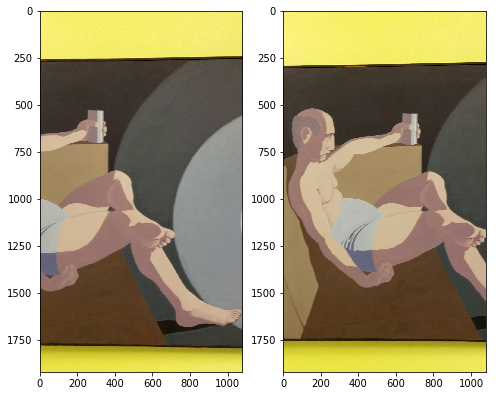

In [4]:
index1 = 3
index2 = 4

img_ = putinColor[index1]
img1 = putin[index1]

img = putinColor[index2]
img2 = putin[index2]

showImages([img_, img])

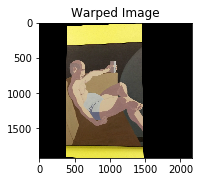

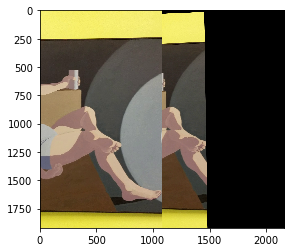

[[ 9.36059064e-01 -1.69026765e-02  3.92523803e+02]
 [-3.69930890e-02  9.24866037e-01  5.75370652e+01]
 [-2.88954442e-05 -2.09680267e-05  1.00000000e+00]]


In [8]:
sift = cv2.xfeatures2d.SIFT_create()
matcher = cv2.BFMatcher()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
# Apply ratio test
good = []
for m in matches:
    if m[0].distance < 0.5*m[1].distance:
        good.append(m)
matches = np.asarray(good)
if len(matches[:,0]) >= 4:
    src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
    #print(H)
else:
    raise AssertionError('Can’t find enough keypoints.')
dst = cv2.warpPerspective(img,H,(img.shape[1] + img_.shape[1], img.shape[0]))
plt.subplot(122),plt.imshow(dst),plt.title('Warped Image')
plt.show()
plt.figure()
dst[0:img.shape[0], 0:img.shape[1]] = img_
plt.imshow(dst)
plt.show()
print(H)



In [11]:

def findHomography(ims, k=2, ratio=0.5, thing=5.0):
    H = []
    kp0, des0 = sift.detectAndCompute(ims[0],None)
    for i in range(1,len(ims)):
        kp1, des1 = sift.detectAndCompute(ims[i],None)
        matches = matcher.knnMatch(des0,des1, k=k)
        good = []
        for m in matches:
            if m[0].distance < ratio*m[1].distance:
                good.append(m)
        matches = np.asarray(good)
        src = np.float32([ kp0[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        dst = np.float32([ kp1[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        h, masked = cv2.findHomography(src, dst, cv2.RANSAC, thing)
        H.append(h)
        kp0 = kp1
        des0 = des1
    return H
def warpImages(ims, H):
    h = H[0]
    out = ims[0]
    for i in range(1, len(ims)):
        out = cv2.warpPerspective(out,h,(2000, 1080))
        if i < len(ims) - 1:
            h = np.multiply(h, H[i])
    return out

In [12]:
HG = findHomography(putin)
print(len(HG))
im = warpImages(putinColor, H)
plt.imshow(im)

5


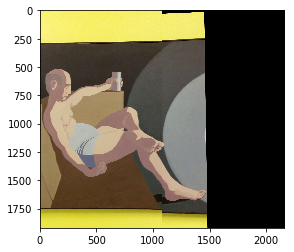

In [14]:
dst = cv2.warpPerspective(img_,H,(img.shape[1] + img_.shape[1], img.shape[0]))
dst[0:img.shape[0], 0:img.shape[1]] = img
plt.imshow(dst)

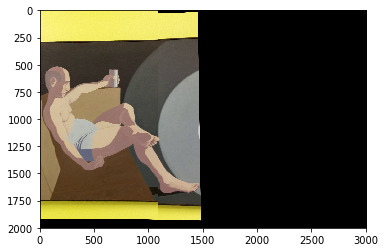

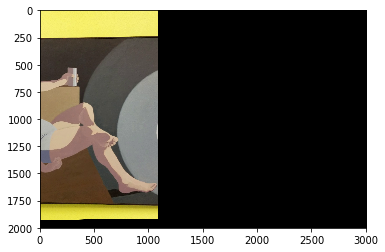

In [15]:
def warp(img1, img2, H, size):
    dst = cv2.warpPerspective(img1,H,size)
    dst[0:img2.shape[0], 0:img2.shape[1]] = img2
    return dst
im = warp(img_, img, HG[3],(3000, 2000))
plt.imshow(im)
plt.figure()
im = warp(img, img_, numpy.linalg.inv(HG[3]),(3000, 2000))
plt.imshow(im)

In [16]:
H

array([[ 9.36059064e-01, -1.69026765e-02,  3.92523803e+02],
       [-3.69930890e-02,  9.24866037e-01,  5.75370652e+01],
       [-2.88954442e-05, -2.09680267e-05,  1.00000000e+00]])

In [18]:
inv = numpy.linalg.inv(H)
inv

array([[ 1.05588776e+00,  9.88788514e-03, -4.15029999e+02],
       [ 4.02831042e-02,  1.08020632e+00, -7.79639789e+01],
       [ 3.13550030e-05,  2.29355098e-05,  9.86372773e-01]])

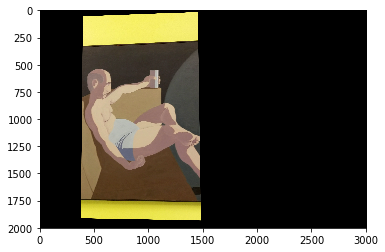

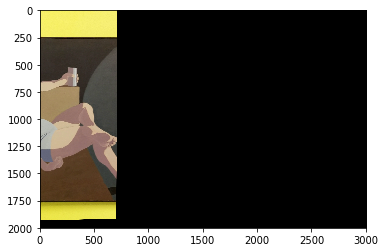

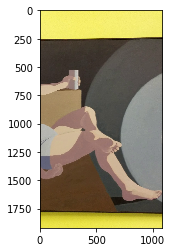

In [21]:

plt.imshow(cv2.warpPerspective(img,H,(3000,2000)))
plt.figure()
plt.imshow(cv2.warpPerspective(img,inv,(3000,2000)))
plt.figure()
plt.imshow(img_)